In [405]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
from IPython.core.display import display

In [361]:
df_raw = pd.read_pickle('../testData/scrobbles_processed/5759068.pkl')


# Artist basis

In [362]:
# def 1: final prop. listens
vc = df_raw['artist_idx'].value_counts()
overall_prop = vc/float(len(df_raw))
overall_prop.name = 'final_value'
df_raw = df_raw.join(overall_prop,on='artist_idx')


In [363]:
# def 2: up-to-moment prop. listens
def calc_c_counts(df):
    df['index'] = range(1,len(df)+1)
    return df
df_raw = df_raw.groupby('artist_idx').apply(calc_c_counts)
df_raw['overall_index'] = df_raw.index + 1
df_raw['current_value'] = df_raw['index'] / df_raw['overall_index']

In [364]:
# def 3: global popularity
artist_pops = pd.Series([line.split(',')[1] for line in open('../GenreModeling/data/artist_pop')],dtype=float)
artist_pops.name = 'global_value'
df_raw = df_raw.join(artist_pops / artist_pops.sum(),on='artist_idx')


In [365]:
### ADD IDF DATA
total_users = 145148.
idf = pd.Series(np.log(total_users / np.loadtxt('../testData/idf_data',dtype=float)))
idf.name = 'idf'
df_raw = df_raw.join(idf,on='artist_idx')


In [366]:
# def 4: tf-idf variant of final prop. listens
df_raw['final_value_tfidf'] = df_raw['final_value'] * df_raw['idf']

In [367]:
# def 5: tf-idf variant of up-to-moment prop. listens
df_raw['current_value_tfidf'] = df_raw['current_value'] * df_raw['idf']

In [368]:
cols = df_raw.columns
#cols = ['artist_idx','ts','final_value','final_value_tfidf','current_value','current_value_tfidf','global_value']
display(df_raw[cols].head())
display(df_raw[cols].tail())

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,index,overall_index,current_value,global_value,idf,final_value_tfidf,current_value_tfidf
0,NaN,50.0,2007-02-24 22:54:28,0.0,0.0,0.0,0.0,0.008686,1.0,1,1.000000,0.001344,0.872338,0.007577,0.872338
1,0.986968,584.0,2007-02-24 22:59:07,0.0,0.0,1.0,1.0,0.002482,1.0,2,0.500000,0.000267,1.822755,0.004523,0.911378
2,0.765355,231.0,2007-02-24 23:01:54,0.0,0.0,2.0,2.0,0.000119,1.0,3,0.333333,0.000539,0.954154,0.000114,0.318051
3,0.925810,747.0,2007-02-25 01:55:39,0.0,0.0,3.0,3.0,0.005218,1.0,4,0.250000,0.000220,2.160909,0.011276,0.540227
4,0.830164,405.0,2007-02-25 02:00:36,0.0,0.0,4.0,4.0,0.005830,1.0,5,0.200000,0.000368,1.704314,0.009936,0.340863


,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,index,overall_index,current_value,global_value,idf,final_value_tfidf,current_value_tfidf
58828,0.0,810.0,2012-12-29 22:06:38,0.0,4044.0,24313.0,22804.0,0.006969,406.0,58829,0.006901,0.000203,2.666308,0.018581,0.018401
58829,0.0,810.0,2012-12-29 22:09:57,0.0,4044.0,24313.0,22804.0,0.006969,407.0,58830,0.006918,0.000203,2.666308,0.018581,0.018446
58830,0.0,810.0,2012-12-29 22:13:33,0.0,4044.0,24313.0,22804.0,0.006969,408.0,58831,0.006935,0.000203,2.666308,0.018581,0.018491
58831,0.0,810.0,2012-12-29 22:16:42,0.0,4044.0,24313.0,22804.0,0.006969,409.0,58832,0.006952,0.000203,2.666308,0.018581,0.018536
58832,0.0,810.0,2012-12-29 22:20:38,0.0,4044.0,24313.0,22804.0,0.006969,410.0,58833,0.006969,0.000203,2.666308,0.018581,0.018581


(0, 0.04)

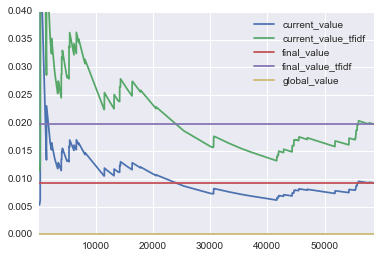

In [369]:
fig,ax = plt.subplots(1,1)
df_raw[df_raw['artist_idx']==1149][['current_value','current_value_tfidf','final_value','final_value_tfidf','global_value']].plot(ax=ax)
ax.set_ylim(0,0.04)

# Patch basis

In [397]:
df_patches_raw = pd.read_pickle('../testData/patches_clustered/5759068.pkl')

In [398]:
# def 1: final prop. listens
#vc = df_patches['patch_clust'].value_counts()
listensPerPatch = df_patches.groupby('patch_clust')['n'].sum()
overall_prop = listensPerPatch/float(df_patches['n'].sum())
overall_prop_exploit = listensPerPatch/float(df_patches.dropna()['n'].sum())
overall_prop.name = 'final_value'
overall_prop_exploit.name = 'final_value_exploit'
df_patches = df_patches_raw.join(overall_prop,on='patch_clust').join(overall_prop_exploit,on='patch_clust')


In [399]:
def calc_c_counts(df):
    df['index'] = df['n'].cumsum()
    return df[['index']]
indices = df_patches_raw.groupby('patch_clust').apply(calc_c_counts)
df_patches['index'] = indices
df_patches['overall_index'] = df_patches['n'].cumsum()
df_patches['current_value'] = df_patches['index'] / df_patches['overall_index']
df_patches['overall_exploit_index'] = np.where(np.isnan(df_patches['patch_clust']),0,df_patches['n']).cumsum()
df_patches['current_value_exploit'] = df_patches['index'] / df_patches['overall_exploit_index']

In [400]:
df_patches[['n','patch_clust','final_value','final_value_exploit','current_value','current_value_exploit']].head(10)

,n,patch_clust,final_value,final_value_exploit,current_value,current_value_exploit
0,69,NaN,NaN,NaN,NaN,NaN
1,16,91.0,0.024017,0.039736,0.188235,1.000000
2,13,53.0,0.008550,0.014145,0.132653,0.448276
3,12,NaN,NaN,NaN,NaN,NaN
4,8,90.0,0.015009,0.024831,0.067797,0.216216
5,24,128.0,0.021553,0.035658,0.169014,0.393443
6,3,NaN,NaN,NaN,NaN,NaN
7,11,128.0,0.021553,0.035658,0.224359,0.486111
8,63,NaN,NaN,NaN,NaN,NaN
9,14,53.0,0.008550,0.014145,0.115880,0.313953


# example analsyes

In [401]:
display(df_raw.head())
display(df_patches.head())

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,final_value,index,overall_index,current_value,global_value,idf,final_value_tfidf,current_value_tfidf,dist_next
0,NaN,50.0,2007-02-24 22:54:28,0.0,0.0,0.0,0.0,0.008686,1.0,1,1.000000,0.001344,0.872338,0.007577,0.872338,0.986968
1,0.986968,584.0,2007-02-24 22:59:07,0.0,0.0,1.0,1.0,0.002482,1.0,2,0.500000,0.000267,1.822755,0.004523,0.911378,0.765355
2,0.765355,231.0,2007-02-24 23:01:54,0.0,0.0,2.0,2.0,0.000119,1.0,3,0.333333,0.000539,0.954154,0.000114,0.318051,0.925810
3,0.925810,747.0,2007-02-25 01:55:39,0.0,0.0,3.0,3.0,0.005218,1.0,4,0.250000,0.000220,2.160909,0.011276,0.540227,0.830164
4,0.830164,405.0,2007-02-25 02:00:36,0.0,0.0,4.0,4.0,0.005830,1.0,5,0.200000,0.000368,1.704314,0.009936,0.340863,0.846672


,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit
0,"[0.00220395499965, 0.00644255506066, 0.0079506...",0.730417,69,2007-02-24 22:54:28,NaN,NaN,NaN,NaN,69,NaN,0,NaN
1,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.000000,16,2007-02-26 07:07:20,91.0,0.024017,0.039736,16.0,85,0.188235,16,1.000000
2,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.000000,13,2007-02-26 09:01:11,53.0,0.008550,0.014145,13.0,98,0.132653,29,0.448276
3,"[0.00053988837863, 0.00230712601993, 0.0017630...",0.718714,12,2007-02-26 20:55:48,NaN,NaN,NaN,NaN,110,NaN,29,NaN
4,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.000000,8,2007-02-27 04:25:49,90.0,0.015009,0.024831,8.0,118,0.067797,37,0.216216


In [419]:
def cos_nan(arr1,arr2):
    if np.any(np.isnan(arr1)) or np.any(np.isnan(arr2)):
        return np.nan
    else:
        return cosine(arr1,arr2)
    
df_patches['next'] = df_patches['centroid'].shift(-1)
df_patches['nextdist'] = df_patches.apply(lambda row: cos_nan(row['centroid'],row['next']),axis=1)

df_patches_exploit = df_patches.dropna()
df_patches_exploit['next'] = df_patches_exploit['centroid'].shift(-1)
df_patches_exploit['nextdist'] = df_patches_exploit.apply(lambda row: cos_nan(row['centroid'],row['next']),axis=1)

display(df_patches.head())
display(df_patches_exploit.head())

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist
0,"[0.00220395499965, 0.00644255506066, 0.0079506...",0.730417,69,2007-02-24 22:54:28,NaN,NaN,NaN,NaN,69,NaN,0,NaN,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.427401
1,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.000000,16,2007-02-26 07:07:20,91.0,0.024017,0.039736,16.0,85,0.188235,16,1.000000,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.262133
2,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.000000,13,2007-02-26 09:01:11,53.0,0.008550,0.014145,13.0,98,0.132653,29,0.448276,"[0.00053988837863, 0.00230712601993, 0.0017630...",0.774041
3,"[0.00053988837863, 0.00230712601993, 0.0017630...",0.718714,12,2007-02-26 20:55:48,NaN,NaN,NaN,NaN,110,NaN,29,NaN,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.375220
4,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.000000,8,2007-02-27 04:25:49,90.0,0.015009,0.024831,8.0,118,0.067797,37,0.216216,"[0.00274972236358, 0.000955550863693, 0.003491...",0.430958


,centroid,diversity,n,start_ts,patch_clust,final_value,final_value_exploit,index,overall_index,current_value,overall_exploit_index,current_value_exploit,next,nextdist
1,"[5.32254464546e-06, 0.00297989085737, 9.176801...",0.0,16,2007-02-26 07:07:20,91.0,0.024017,0.039736,16.0,85,0.188235,16,1.000000,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.262133
2,"[1.79202689245e-07, 0.017360152999, 1.79202689...",0.0,13,2007-02-26 09:01:11,53.0,0.008550,0.014145,13.0,98,0.132653,29,0.448276,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.686697
4,"[4.18075798112e-08, 4.18075798112e-08, 6.05708...",0.0,8,2007-02-27 04:25:49,90.0,0.015009,0.024831,8.0,118,0.067797,37,0.216216,"[0.00274972236358, 0.000955550863693, 0.003491...",0.430958
5,"[0.00274972236358, 0.000955550863693, 0.003491...",0.0,24,2007-02-27 05:19:15,128.0,0.021553,0.035658,24.0,142,0.169014,61,0.393443,"[0.00274972236358, 0.000955550863693, 0.003491...",0.000000
7,"[0.00274972236358, 0.000955550863693, 0.003491...",0.0,11,2007-02-28 01:51:39,128.0,0.021553,0.035658,35.0,156,0.224359,72,0.486111,"[2.19839174458e-07, 0.0184632976208, 2.1983917...",0.819032


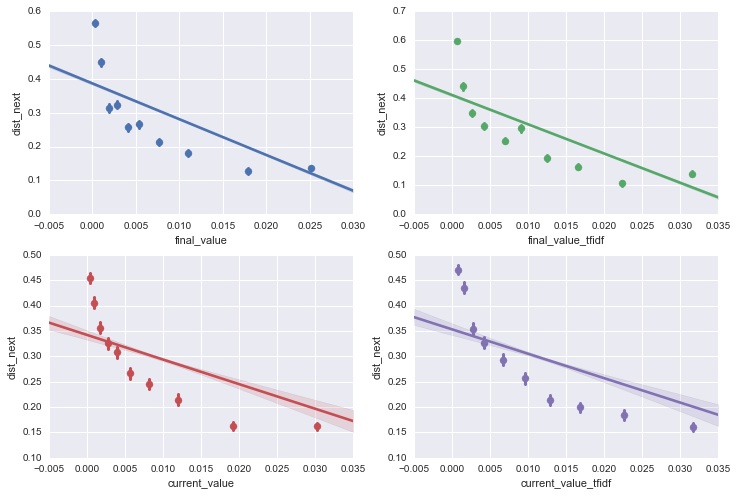

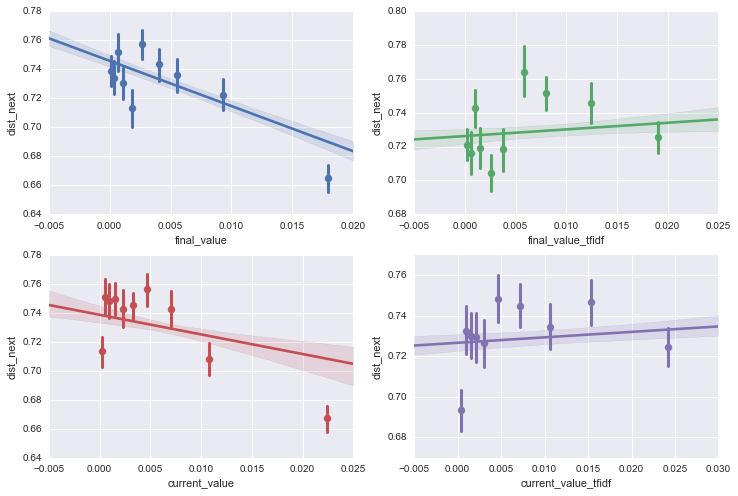

In [418]:
df_raw['dist_next'] = df_raw['dist'].shift(-1)
blocked = df_raw.groupby('block').apply(lambda x: x.iloc[-1])

xbins = 10
# jump distance as a function of value (by listen)
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
seaborn.regplot(x='final_value',y='dist_next',data=df_raw,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='final_value_tfidf',y='dist_next',data=df_raw,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='current_value',y='dist_next',data=df_raw,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='current_value_tfidf',y='dist_next',data=df_raw,x_bins=xbins,ax=ax)

# jump distance as a function of value (by block)
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
seaborn.regplot(x='final_value',y='dist_next',data=blocked,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='final_value_tfidf',y='dist_next',data=blocked,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='current_value',y='dist_next',data=blocked,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='current_value_tfidf',y='dist_next',data=blocked,x_bins=xbins,ax=ax)


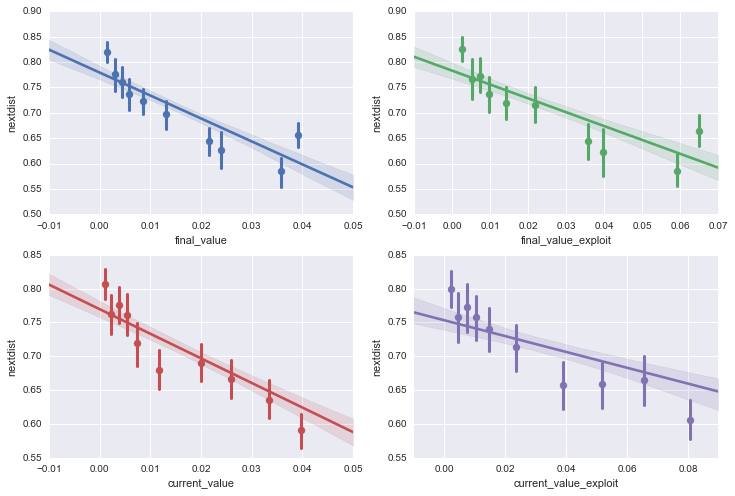

In [420]:
# jump distance as a function of value (by patch)
fig,axes = plt.subplots(2,2,figsize=(12,8))
axes = axes.flat
ax = axes.next()
seaborn.regplot(x='final_value',y='nextdist',data=df_patches,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='final_value_exploit',y='nextdist',data=df_patches_exploit,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='current_value',y='nextdist',data=df_patches,x_bins=xbins,ax=ax)
ax = axes.next()
seaborn.regplot(x='current_value_exploit',y='nextdist',data=df_patches_exploit,x_bins=xbins,ax=ax)

In [ ]:
df_patches.drop('')